[View in Colaboratory](https://colab.research.google.com/github/Hoiy/kaggle-santander-value-prediction-challenge/blob/master/prep.ipynb)

In [10]:
import pandas as pd
import numpy as np
import os
import dotenv
import gc
from tqdm import tqdm 
from sklearn.feature_extraction.text import CountVectorizer

dotenv.load_dotenv('.env')

True

In [0]:
types = ['train', 'test']
dfs = {t:pd.read_csv('./raw_data/%s.csv'%t).set_index('ID') for t in types}

In [12]:
train_target = dfs['train'][['target']]
train_target.to_parquet('./prep/train_target.snappy.parquet')

raw_feats = {}
for t in types:
  raw_feats[t] = dfs[t][dfs[t].columns[-4991:]]
  raw_feats[t].to_parquet('./prep/%s_raw_feats.snappy.parquet'%t)
  

KeyboardInterrupt: ignored

In [0]:
train_target = pd.read_parquet('./prep/train_target.snappy.parquet')
raw_feats = {}
for t in types:
  raw_feats[t] = pd.read_parquet('./prep/%s_raw_feats.snappy.parquet'%t)

In [0]:
train_target.head(), raw_feats['train'].head(), raw_feats['test'].head()

(               target
 ID                   
 000d6aaf2  38000000.0
 000fbd867    600000.0
 0027d6b71  10000000.0
 0028cbf45   2000000.0
 002a68644  14400000.0,
            48df886f9  0deb4b6a8  34b15f335  a8cb14b00  2f0771a37  30347e683  \
 ID                                                                            
 000d6aaf2        0.0          0        0.0          0          0          0   
 000fbd867        0.0          0        0.0          0          0          0   
 0027d6b71        0.0          0        0.0          0          0          0   
 0028cbf45        0.0          0        0.0          0          0          0   
 002a68644        0.0          0        0.0          0          0          0   
 
            d08d1fbe3  6ee66e115  20aa07010  dc5a8f1d8    ...      3ecc09859  \
 ID                                                       ...                  
 000d6aaf2          0          0        0.0        0.0    ...            0.0   
 000fbd867          0          0  22

In [3]:
# # Drop constant columns
# def constant_columns(df):
#   constant_cols = []
#   for col in df.columns:
#     if len(df[col].unique()) <= 1:
#       constant_cols.append(col)
    
#   return constant_cols

# constant_cols = constant_columns(dfs['train'])
# print("Droping %d constant columns..."%len(constant_cols))

# for t in types:
#   dfs[t] = dfs[t].drop(columns=constant_cols)
feats = raw_feats

NameError: ignored

In [0]:
# stats for original values

# for t in types:
#   dfs[t].replace(0, np.NaN)
#   feats = dfs[t][feat_cols]
  
#   dfs[t]['count'] = feats.count(axis=1, numeric_only=True)
#   dfs[t]['mean'] = feats.mean(axis=1, numeric_only=True)
#   dfs[t]['median'] = feats.median(axis=1, numeric_only=True)
  
#   dfs[t]['min'] = feats.min(axis=1, numeric_only=True)
#   dfs[t]['max'] = feats.max(axis=1, numeric_only=True)
#   dfs[t]['25_percentile'] = feats.quantile(0.25 ,axis=1, numeric_only=True)
#   dfs[t]['75_percentile'] = feats.quantile(0.75 ,axis=1, numeric_only=True)

#   dfs[t]['var'] = feats.var(axis=1, numeric_only=True)
#   dfs[t]['std'] = feats.std(axis=1, numeric_only=True)
  
#   dfs[t]['skew'] = feats.skew(axis=1, numeric_only=True)
#   dfs[t]['kurt'] = feats.kurt(axis=1, numeric_only=True)  

In [5]:
# log features and target
train_log_target = np.log1p(train_target)
train_log_target.to_parquet('./prep/train_log_target.snappy.parquet')

log_feats = {}
for t in types:
  log_feats[t] = np.log1p(feats[t]).replace(0, np.NaN)
  log_feats[t].to_parquet('./prep/%s_log_feats.snappy.parquet'%t)


NameError: ignored

In [0]:
train_log_target = pd.read_parquet('./prep/train_log_target.snappy.parquet')
log_feats = {}
for t in types:
  log_feats[t] = pd.read_parquet('./prep/%s_log_feats.snappy.parquet'%t)
  
train_log_target.head(), log_feats['train'].head(), log_feats['test'].head()

(              target
 ID                  
 000d6aaf2  17.453097
 000fbd867  13.304687
 0027d6b71  16.118096
 0028cbf45  14.508658
 002a68644  16.482739,
            48df886f9  0deb4b6a8  34b15f335  a8cb14b00  2f0771a37  30347e683  \
 ID                                                                            
 000d6aaf2        NaN        NaN        NaN        NaN        NaN        NaN   
 000fbd867        NaN        NaN        NaN        NaN        NaN        NaN   
 0027d6b71        NaN        NaN        NaN        NaN        NaN        NaN   
 0028cbf45        NaN        NaN        NaN        NaN        NaN        NaN   
 002a68644        NaN        NaN        NaN        NaN        NaN        NaN   
 
            d08d1fbe3  6ee66e115  20aa07010  dc5a8f1d8    ...      3ecc09859  \
 ID                                                       ...                  
 000d6aaf2        NaN        NaN        NaN        NaN    ...            NaN   
 000fbd867        NaN        NaN  14.603968

In [0]:
train_target_in_feat = pd.merge(train_log_target, log_feats['train'], left_index=True, right_index=True, how='inner').apply(lambda x: x[0] in x[1:].values, axis=1).to_frame('target_in_feat')
train_target_in_feat.to_parquet('./prep/train_target_in_feat.snappy.parquet')

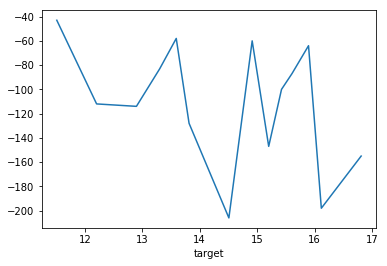

In [0]:
high_freq_target = train_log_target.groupby('target').size().diff().shift(-1).fillna(True)
high_freq_target = high_freq_target[high_freq_target < -40]
high_freq_target.plot.line()
high_freq_target.index

train_target_is_high_freq = train_log_target.target.apply(lambda x: x in high_freq_target.index.values).to_frame('target_in_high_freq')
train_target_is_high_freq.to_parquet('./prep/train_target_in_high_freq.snappy.parquet')

In [0]:
MODE_COUNT = 10

mode = {}
for t in types:
  mode[t] = log_feats[t].mode(axis=1)
  mode[t]['mode_count'] = mode[t].apply(lambda x: x.dropna().count(), axis=1)
  mode[t] = mode[t][['mode_count'] + list(range(MODE_COUNT))].rename(columns={i:'mode_%d'%i for i in range(MODE_COUNT)})
  mode[t].to_parquet('./prep/%s_mode.snappy.parquet'%t)

In [0]:
mode = {}
for t in types:
  mode[t] = pd.read_parquet('./prep/%s_mode.snappy.parquet'%t)

In [0]:
.col_stats = {}
for t in types:
  col_stats[t] = pd.DataFrame({
      'count': log_feats[t].count(numeric_only=True),
      'unique': log_feats[t].nunique(dropna=True),
      'log_mean': log_feats[t].mean(numeric_only=True),
      'log_median': log_feats[t].median(numeric_only=True),
      'log_min': log_feats[t].min(numeric_only=True),
      'log_max': log_feats[t].max(numeric_only=True),
      'log_25_percentile': log_feats[t].quantile(0.25 ,numeric_only=True),
      'log_75_percentile': log_feats[t].quantile(0.75 ,numeric_only=True),
      'log_var': log_feats[t].var(numeric_only=True),
      'log_std': log_feats[t].std(numeric_only=True),
      'log_skew': log_feats[t].skew(numeric_only=True),
      'log_kurt': log_feats[t].kurt(numeric_only=True),
  }, index=log_feats[t].columns)
  col_stats[t].to_parquet('./prep/%s_col_stats.snappy.parquet'%t)

/usr/local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:907: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


In [0]:
col_stats['train']

,count,unique,log_mean,log_median,log_min,log_max,log_25_percentile,log_75_percentile,log_var,log_std,log_skew,log_kurt
48df886f9,39,31,12.797465,12.542548,10.239996,16.811243,11.651750,13.381762,2.692009,1.640734,0.773923,0.127711
0deb4b6a8,4,4,12.927873,13.905003,8.699681,15.201805,12.536554,14.296322,8.324651,2.885247,-1.718638,3.251399
34b15f335,33,28,13.662394,13.883170,10.308986,16.811243,11.695255,15.424949,3.932311,1.983006,-0.037823,-1.316171
a8cb14b00,2,2,16.006024,16.006024,15.501910,16.510138,15.753967,16.258081,0.508262,0.712925,NaN,NaN
2f0771a37,5,5,14.500298,14.755518,10.896758,18.420681,11.904974,16.523561,9.812334,3.132465,0.057990,-1.937423
30347e683,47,24,13.971527,13.641158,11.877576,16.846031,13.122365,14.304091,1.570499,1.253196,0.823891,0.091546
d08d1fbe3,5,5,14.523416,15.201805,8.699681,17.504390,13.994494,17.216708,12.698971,3.563562,-1.393321,1.938369
6ee66e115,5,5,14.737521,14.508658,13.304687,16.157316,14.014362,15.702580,1.393877,1.180626,0.108633,-1.938156
20aa07010,1494,713,14.424673,14.603968,7.601402,19.582618,13.276294,15.894952,4.241997,2.059611,-0.716853,0.503522
dc5a8f1d8,123,55,14.572772,14.845130,6.398595,17.909855,14.200565,16.118096,3.618567,1.902253,-1.545247,3.029239


In [0]:
# stats for log values
pd.options.mode.use_inf_as_na = True

log_stats = {}
for t in types:
  log_stats[t] = pd.DataFrame({
      'count': log_feats[t].count(axis=1, numeric_only=True),
      'unique': log_feats[t].nunique(axis=1, dropna=True),
      'log_mean': log_feats[t].mean(axis=1, numeric_only=True),
      'log_median': log_feats[t].median(axis=1, numeric_only=True),
      'log_min': log_feats[t].min(axis=1, numeric_only=True),
      'log_max': log_feats[t].max(axis=1, numeric_only=True),
      'log_25_percentile': log_feats[t].quantile(0.25 ,axis=1, numeric_only=True),
      'log_75_percentile': log_feats[t].quantile(0.75 ,axis=1, numeric_only=True),
      'log_var': log_feats[t].var(axis=1, numeric_only=True),
      'log_std': log_feats[t].std(axis=1, numeric_only=True),
      'log_skew': log_feats[t].skew(axis=1, numeric_only=True),
      'log_kurt': log_feats[t].kurt(axis=1, numeric_only=True),
  }, index=log_feats[t].index)
  log_stats[t].to_parquet('./prep/%s_log_stats.snappy.parquet'%t)
  log_stats[t] = pd.read_parquet('./prep/%s_log_stats.snappy.parquet'%t)

In [0]:
# docs = {}
# for t in types:
#   docs[t] = log_feats[t].values.tolist()
#   docs[t] = [[x for x in doc if x >= 0] for doc in docs[t]]

In [0]:
# Counter vectorizer

# vectorizer = CountVectorizer(tokenizer=lambda x: x, preprocessor=None, lowercase=False)
# # vectorizer.vocabulary

# dfs['train'] = pd.concat([dfs['train'], pd.DataFrame(vectorizer.fit_transform(docs['train']).toarray())], axis=1)
# dfs['test'] = pd.concat([dfs['test'], pd.DataFrame(vectorizer.transform(docs['test']).toarray())], axis=1)

In [0]:
# occur count
# for t in types:
#   dfs[t]['occurs_count'] = dfs[t].apply(lambda x: len(x[2:][x[2:] == x.target]), axis=1)

In [0]:
!gsutil rsync prep gs://{os.environ['GCP_BUCKET']}/prep

Building synchronization state...
Starting synchronization...
Copying file://prep/test_log_feats.snappy.parquet [Content-Type=application/octet-stream]...
Copying file://prep/test_log_stats.snappy.parquet [Content-Type=application/octet-stream]...
Copying file://prep/test_raw_feats.snappy.parquet [Content-Type=application/octet-stream]...
Copying file://prep/train_log_feats.snappy.parquet [Content-Type=application/octet-stream]...
\
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m -o ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://prep/train_log_stats.snappy.parquet [Content-Type=application/octet-stream]...
Copying file://prep/train_log_target.snappy.parquet [Content-Type=application/octet-stream]...
Copying file://prep/train_raw_feats.snappy.parquet [Content-Type=application/octet-stream]...
Copying file://prep/train_ta